## <img src = "https://drive.google.com/uc?id=1_5Jg5fewO7ds4CVEuoj-tsRI1CFgW0IW" width="100px"> **Перед началом работы нужно сменить среду выполнения. Для этого перейдите сверху в раздел "Среда выполнения", дальше выберите "Сменить среду выполнения" и выберите T4 GPU, дальше сохранить изменения.**

# Семинар 1

**Нейронные сети и PyTorch: быстрый старт.**

# **Подсказки для работы с MacBook**

**Работа с ячейками и кодом:**

- Command + / : комментирование кода.
- Command+X: вырезать выделенный объект и скопировать его в буфер обмена.
- Command+C: копировать выделенный объект в буфер обмена.
- Command+V: вставка содержимого буфера обмена в текущий документ или программу.  
- Command+Z: отмена предыдущей команды. Отмену также можно обратить, нажав клавиши Command-Shift-Z для повтора отмененной команды.  
- Command+A: выбрать все объекты.
- Command+F: найти объекты в документе.    
- Command+S: сохранение текущего документа.
- Command+T: открытие новой вкладки.

**Смена языка:**

- Command (⌘) + пробел

**Работа с окнами:**

- Command+W: закрыть активное окно.
- Option+Command+W: закрыть все открытые окна.
- Command+M: свернуть активное окно.
- Command+Tab: переключиться на окно предыдущего приложения.
- Command+H: скрыть активное приложение.

**Жест трекпада:**

Если у вас Macbook, и вы пользуетесь трекпадом, то окна можно переключать и по-другому. Проведите по трекпаду тремя пальцами, а затем наведите курсор на программу, которую хотите открыть.

## **Базовые подходы**
Основная задача данного семинара - знакомство с методами построения полносвязной сети на датасете MNIST и работа с библиотекой PyTorch. Но начнем мы с того, что поработаем с датасетом  MNIST и повторим такие подходы в задаче классификации, как логистическая регрессия, градиентный бустинг и деревья решений.

## 1) Датасет MNIST

Будем строить модель для решения задачи классификации рукописных цифр

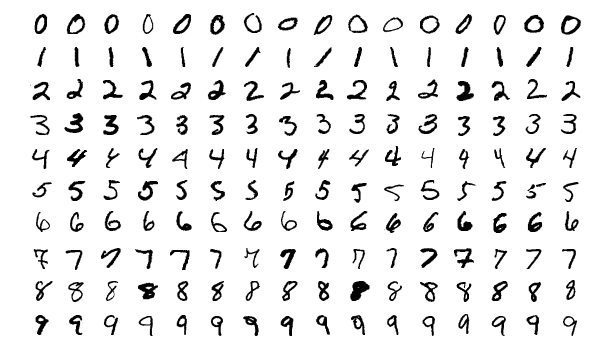

Нам нужно распознать рукописные цифры по их изображениям. Так как цифр 10, то в нашей задаче классификации 10 классов.

Рассматриваемый на этом семинаре набор данных MNIST часто используется для демонстрации возможностей различных алгоритмов машинного и глубинного обучения, так как на нем довольно просто добиться хорошей точности предсказаний.

### 1.1) Подгрузка нужных библиотек

In [1]:
import time

# Импортируем numpy и matplotlib для визуализации данных
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
# Подгружаем наш набор данных
from torchvision.datasets import MNIST

# Класс для трансформации изображений
import torchvision.transforms as transforms

### 1.2) Загружаем датасет и делаем предобработку данных

**Воспользуемся датасетом из библиотеки PyTorch, с которой подробнее познакомимся немного позже. Это позволит нам сравнивать наши эксперименты на одинаковой основе. Ранее мы использовали датасет из библиотеки sklearn, но, учитывая, что в библиотеках sklearn и PyTorch могут быть различия в примерах и их количестве, мы решили для обеспечения точности результатов провести анализ на одной и той же выборке.**

In [3]:
transform_steps = transforms.Compose([
    transforms.ToTensor(), # Преобразуем в тензор
    transforms.Normalize((0.1307,), (0.3081,)) # Нормализируем
])

In [4]:
# # Загружаем обучающую выборку MNIST, при этом сразу трансформируем в формат torch
train = MNIST(root='data/', download=True, train=True, transform=transform_steps)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 500kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.19MB/s]


In [5]:
# Создание генератора для воспроизводимости
generator = torch.Generator()
generator.manual_seed(42)

# Выделяем обучающую подвыборку
train_, _ = torch.utils.data.random_split(train, (50_000, 10_000), generator=generator)

In [6]:
# Загружаем тестовую выборку MNIST
test_ = MNIST(root='data/', download=True, train=False, transform=transform_steps)

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_, batch_size=len(train_), shuffle=True, generator=generator)
test_loader = DataLoader(test_, batch_size=len(test_), shuffle=False)

images_train, labels_train = next(iter(train_loader))
images_test, labels_test = next(iter(test_loader))

In [8]:
images_train.shape, labels_train.shape

(torch.Size([50000, 1, 28, 28]), torch.Size([50000]))

In [9]:
images_test.shape, labels_test.shape

(torch.Size([10000, 1, 28, 28]), torch.Size([10000]))

In [10]:
X_train = images_train.view(images_train.shape[0], -1).numpy()
X_test = images_test.view(images_test.shape[0], -1).numpy()
y_train = labels_train.view(labels_train.shape[0], -1).numpy()
y_test = labels_test.view(labels_test.shape[0], -1).numpy()

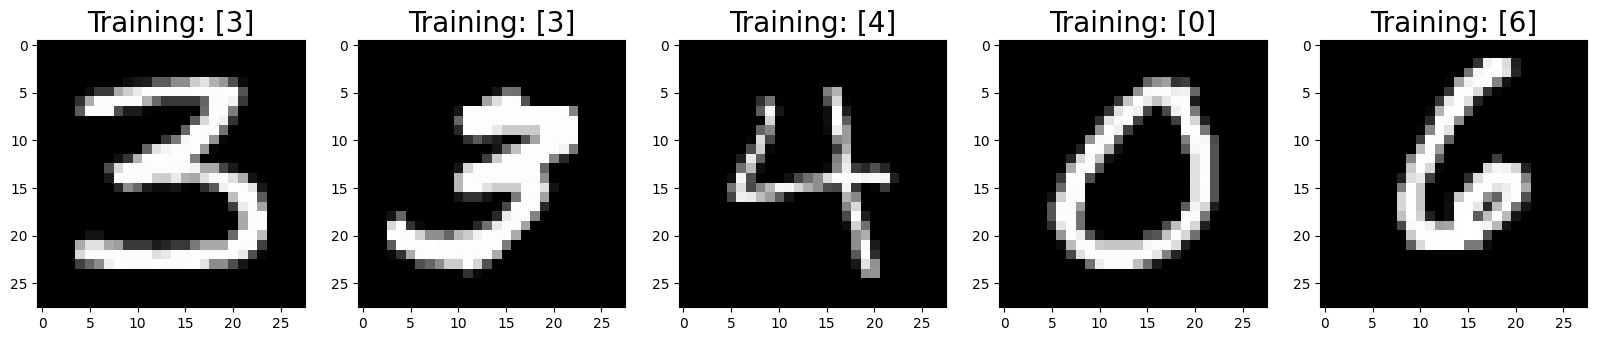

In [11]:
plt.figure(figsize=(20, 4))
for index, (image, label) in enumerate(zip(X_train[0:5], y_train[0:5])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28, 28)), cmap=plt.cm.gray)
    plt.title('Training: ' + str(label), fontsize=20);

In [12]:
X_train

array([[-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       ...,
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, ..., -0.42421296,
        -0.42421296, -0.42421296]], dtype=float32)

## 2) Обучение модели - Логистическая Регрессия

In [13]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42)

In [14]:
%%time
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: user 48 s, sys: 233 ms, total: 48.2 s
Wall time: 27.3 s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

### Считаем точность на тестовой выборке

In [15]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.923

## **Задание**: Обучение модели - Дерево решений

In [16]:
from sklearn.tree import DecisionTreeClassifier

# Проведите инициализацию модели и задайте параметр random_state
dec_tree = DecisionTreeClassifier(random_state=42)

In [19]:
%%time
# Проведите обучение модели
# Ваш код
dec_tree.fit(X_train, y_train)

CPU times: user 18.7 s, sys: 15.6 ms, total: 18.7 s
Wall time: 18.8 s


DecisionTreeClassifier(random_state=42)

### Считаем точность на тестовой выборке

In [20]:
from sklearn.metrics import accuracy_score

# Посчитайте точность
#y_pred = # Ваш код

y_pred = dec_tree.predict(X_test)
accuracy_score(y_test, y_pred)

0.8746

## 3) Обучение модели - Градиентный бустинг

In [23]:
import xgboost as xgb

model = xgb.XGBClassifier(seed=42)

In [24]:
%%time
model.fit(X_train, y_train, verbose=True)

CPU times: user 7min 12s, sys: 724 ms, total: 7min 13s
Wall time: 7min 21s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Считаем точность на тестовой выборке

In [ ]:
from sklearn import metrics

# Делаем предсказания с помощью обученной модели
expected_y  = y_test
predicted_y = model.predict(X_test)

# Выводим результаты тестирования
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 968    1    2    0    0    2    3    1    3    0]
 [   0 1125    3    1    0    1    2    1    2    0]
 [   2    0 1005    8    1    0    1    7    7    1]
 [   0    0    4  989    0    4    0    8    4    1]
 [   0    0    4    1  957   

<Axes: >

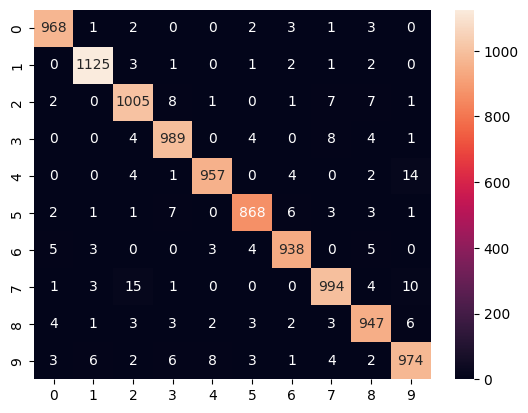

In [ ]:
import seaborn as sns

sns.heatmap(metrics.confusion_matrix(expected_y, predicted_y), annot=True, fmt='g')

## **Machine Learning** vs **Deep Learning**






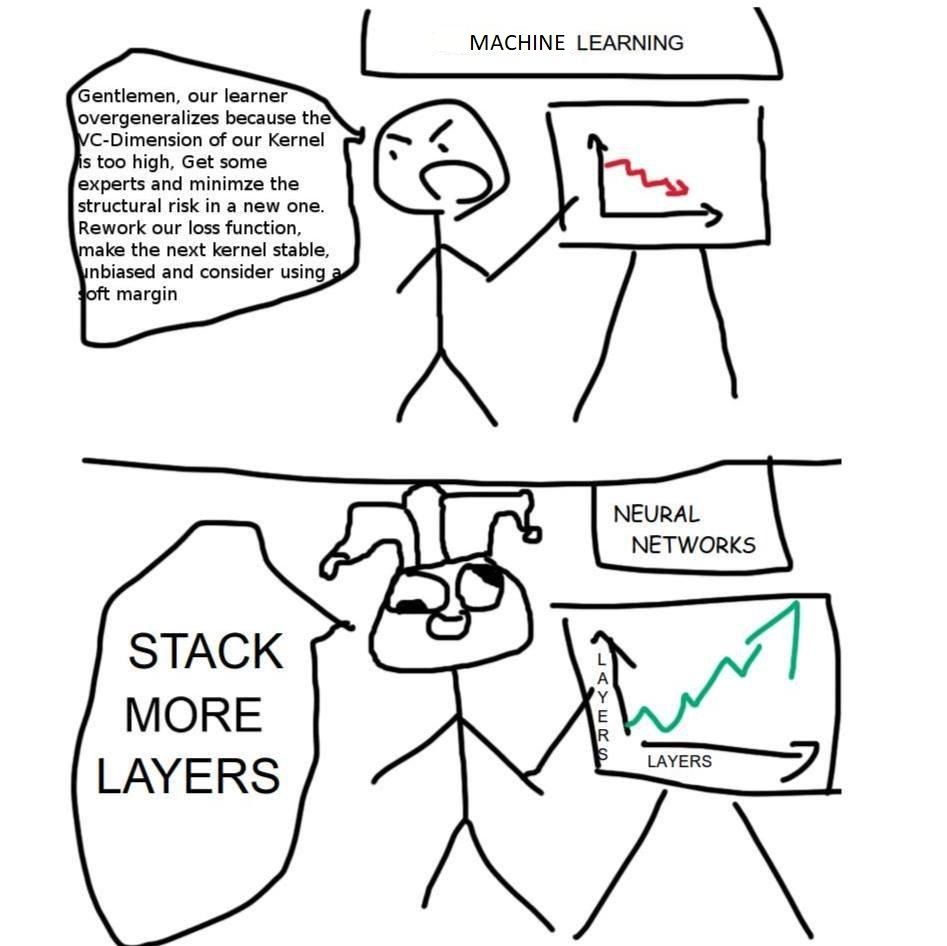

## 1) Что такое нейросеть?

Концепции нейрона, полносвязного слоя, глубокого обучения












### Нейрон (модель перцептрона)



Простейшая нейросеть состоит из **нейронов** - вычислительных узлов.

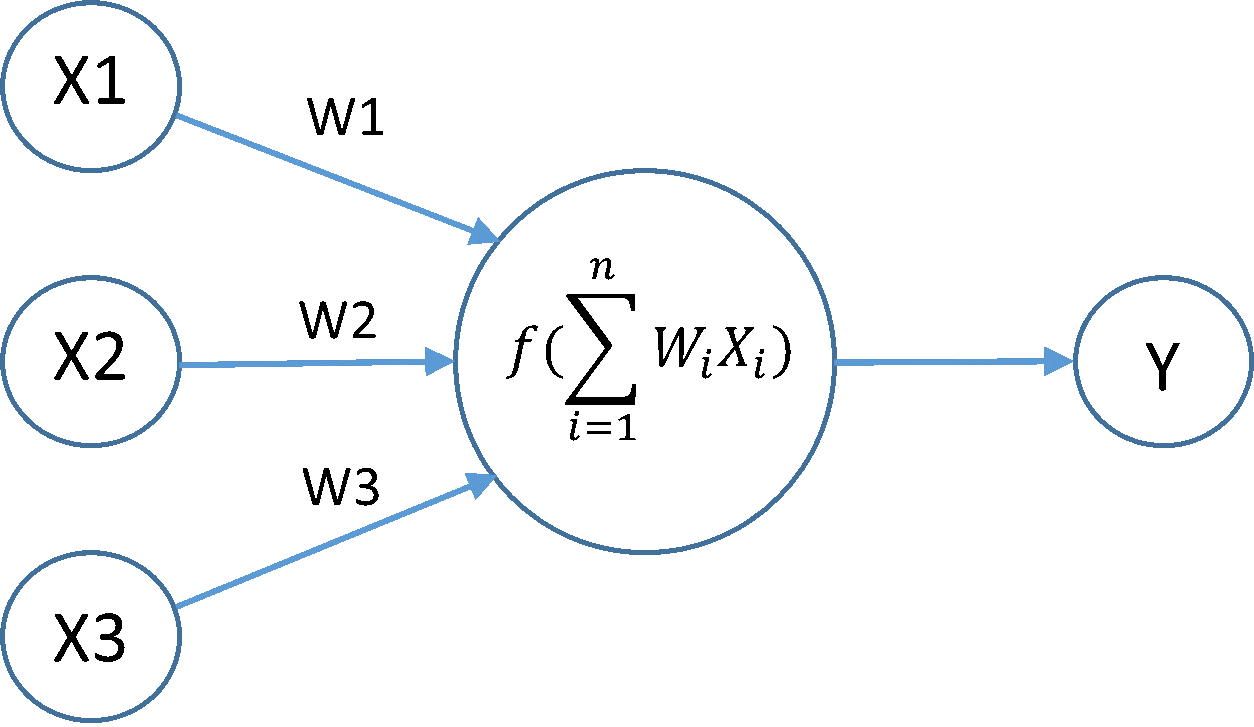


$Y = f(w_1*X_1+w_2*X_2+w_3*X_3)$

Каждый узел принимает на вход численную информацию **input** ($X1, X2, X3$), производит над ней некую арифметическую операцию **$f(\sum_{i=1}^nw_iX_i)$** и передает результат **output** ($Y$) дальше по сети.

**$w_1, w_2, w_3$** - параметры нейрона, называющиеся **весами**.

Чтобы добавить к поведению нейрона **нелинейность** (а умножение входных данных $X$ на параметры $w$ - линейная операция), то есть усложнить сеть, используются **функции активации** $f$.

**Примеры:**

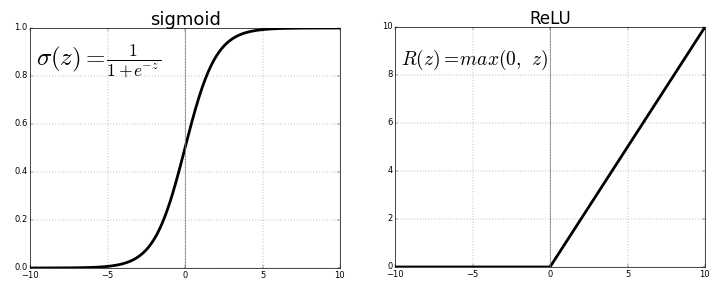

Чтобы оценить качество работы нейронной сети и отразить расхождение между ожидаемым и полученным ответами, существуют **функции ошибки**.

**Примеры**:

**Среднеквадратичная ошибка (регрессия):** $MSE(y,\hat{y}) = (y-\hat{y})^2$

**Логистическая функция ошибки (классификация):** $LogLoss(y,p) = -y\log(p)-(1-y)\log(1-p)$

### Linear Layer (Полносвязный слой)

Нейроны объединяются в слои. Из рассмотренной выше модели нейронов получаются **dense** (полносвязные) слои нейронов: все элементы входных данных связаны с каждым нейроном.

Слои нейронов между входными и выходными данными называются **hidden** (скрытыми) слоями. Чем больше слоев, тем **глубже** нейросеть.

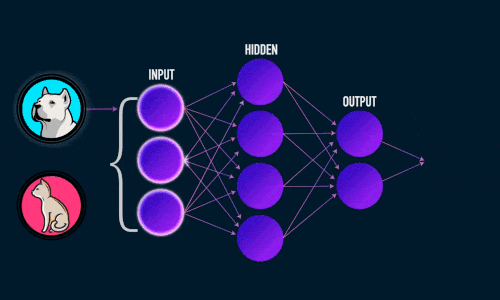

### Глубокое обучение










Совместное обучение большого числа различных слоев нейросети.

*   Нейросеть можно строить из множества "блоков" (слоев), как конструктор.
*   Каждый блок может обладать своей архитектурой, независимо вычисляя выходные данные и градиенты.

<table>
<tr>
<td><img src="https://spectrum.ieee.org/image/MjkxMjcwNg.octet-stream" width="400"></td>
<td><img src="https://img.icons8.com/plasticine/2x/arrow.png" width="200"></td>
<td><img src="https://pics.livejournal.com/xotab_81/pic/001zc7aq" width="500"></td>
</tr>

<tr>
<td><img src="https://sun9-30.userapi.com/c205516/v205516565/aa67/iSeJ8ImWr6A.jpg" width="400"></td>
<td><img src="https://img.icons8.com/plasticine/2x/arrow.png" width="200"></td>
<td><img src="https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/download/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" width="500"></td>
</tr>
</table>


## 2) Библиотека PyTorch


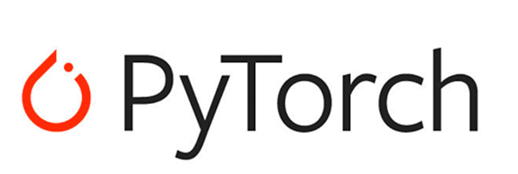

Основные возможности:

* Библиотека для машинного обучения (прежде всего, для обучения нейронных сетей)

* **PyTorch** - низкоуровневая библиотека. Многие вещей в ней приходится прописывать самостоятельно (в отличие, например, от keras). Это позволяет более гибко настраивать обучение и сами модели.

* Основные принципы:
    1. Удобство использования
    2. Модульность
    3. Масштабируемость
    4. Работа с Python

**PyTorch** - одна из самых популярных библиотек для глубинного обучения.

Внутренняя часть библиотеки полностью написана на языке C++. Высокоуровневый код на Python позволяет использовать это эффективно. В итоге мы получаем крайне быстрый функционал.

## 3) MNIST

Как говорили выше, мы будем работать с выборкой рукописных цифр MNIST.

### Пререквизиты:
* `!pip install numpy`
* `!pip install pytorch`
* `!pip install torchvision`

### Процесс анализа данных:
1. Загрузим данные для обучения и тестирования
2. Предобработаем данные
3. Создадим модель для обучения
4. Обучим модель
5. Протестируем модель
6. Попробуем улучшить модель

Загрузим необходимые библиотеки: `torch` - для работы с нейросетями, `numpy`  - для научных вычислений, `matplotlib` - для построения графиков.

* Наша нейронная сеть будет делать ряд последовательных преобразований входных данных. Для реализации данного процесса мы импортируем модуль `nn` из библиотеки PyTorch `torch.nn`. В нем содержится общий класс нейронной сети `nn.Module`, функции активации, разные виды слоев и много другого.  

Мы будем использовать данные MNIST, они лежат в библиотеке `torchvision`. Torchvision - это надстройка над Pytoch, в которой есть дополнительный функционал для задач компьютерного зрения.

Выполните ячейку ниже:

In [25]:
# Импортируем сам torch
import torch
# Импортируем модуль со всеми нужными частями нейросети
from torch import nn

import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [26]:
# Создание генератора для воспроизводимости
generator = torch.Generator()
generator.manual_seed(42)

### Utils

Здесь некоторые дополнительные функции, которые облегчат нам работу с данными. В них разбираться не нужно - только запустить.

In [27]:
def plot_MNIST_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN сэмплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples
  """
  plt.figure(figsize=(10, 10))
  data1=image_data[: N * N]

  image_width = image_data.shape[1]
  image_heigth = image_data.shape[2]

  if len(data1.shape) == 4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N, image_width, image_heigth, image_channels)
    data1 = np.transpose(data1, (0, 2, 1, 3, 4))
    data1 = data1.reshape(N * image_width, N * image_heigth, image_channels)
    plt.imshow(data1)

  elif len(data1.shape) == 3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1, (0, 2, 1, 3))
    data1 = data1.reshape(N * image_width, N * image_heigth)
    plt.imshow(data1, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First ' + str(N * N) + ' ' + dataset_name + ' samples of training set')
  plt.show()

def plot_MNIST_samples(image_data, label_data, classes,  N=8):
  """
    Эта функция строит N самплов каждого класса из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape
        (number_of_samples, image_width, image_height, number of channels)
        with images
    label_data : array
        Array of shape
        (number_of_samples, )
        with labels
    classes : list
        list with classes names
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Number of samples for each class
  """
  plt.figure(figsize=(10, N))
  num_classes = len(classes)
  for i, y in enumerate(classes):
      idxs = np.flatnonzero(label_data == y)
      idxs = np.random.choice(idxs, N, replace=False)
      for i, idx in enumerate(idxs):
          plt_idx = i * num_classes + y + 1
          plt.subplot(N, num_classes, plt_idx)
          plt.imshow(image_data[idx], cmap='gray')
          plt.axis('off')
          if i == 0:
              plt.title(str(y))
  plt.show()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(
        cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues
    ):
    """
    Эта функция выводит confusion matrix.
    Нормализация может быть добавлена изменением значения флага
    `normalize` на `True`
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """
    Эта функция показывает 6 картинок с предсказанными и настоящими классами
    """
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.tight_layout()

### 1. Загрузка данных.

Загрузим набор данных из библиотеки `torchvision`, надстройки над PyTorch.

В Torchvision есть различные трансформации для изображений, например, переворты, приближения и тд. Мы их импортируем. В данном случае будет применяться трансформация в тензорный тип данных из библиотеки PyTorch и нормализация значений.

In [28]:
# Подгружаем наш набор данных
from torchvision.datasets import MNIST

# Класс для трансформации изображений
import torchvision.transforms as transforms

Создадим переменную, в которой находятся все трансформации. В нормализации используются две константы. Они были подобраны на большом количетсве различных картинок и показывают лучший результат при обучении.

In [29]:
transform_steps = transforms.Compose([
    transforms.ToTensor(), # Преобразуем в тензор
    transforms.Normalize((0.1307,), (0.3081,)) # Нормализируем
])

Далее при подгрузке мы можем указать преобразования данных

In [30]:
# Загружаем обучающую выборку MNIST, при этом сразу трансформируем в формат torch
train = MNIST(root='data/', download=True, train=True, transform=transform_steps)

Разделим обучающие данные на train и val. Для этого мы воспользуемся `random_sample`. Передадим в него наш класс датасета и размеры двух новых выборок. Он упакует их в еще один класс - Subset и вернет две переменные. Это просто надстройка, в которой есть сами данные без разбиения и индексы соотвествующей выборки.

In [31]:
train, val = torch.utils.data.random_split(train, (50_000, 10_000), generator=generator)

In [32]:
train[0][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

In [33]:
# Загружаем тестовую выборку MNIST
test = MNIST(root='data/', download=True, train=False, transform=transform_steps)

In [34]:
test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

MNIST возвращает нам класс. Для решения задачи нам понадобятся сами изображения и метки классов для них. Для этого мы будем выбирать из класса два набор значений

`train.dataset.data` - массив со всеми изображениями

`train.dataset.train_labels` - массив с метками классов

Посмотрим на содержание датасета, вызвав функцию `plot_MNIST_samples`,
которая строит на одной картинке **N** примеров из массива картинок
**train.dataset.data** для каждого класса

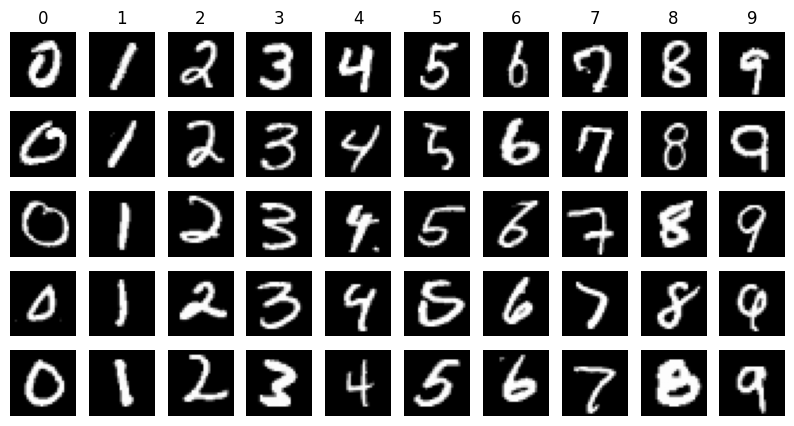

In [35]:
# Создадим лист с именами классов - цифрами от 0 до 9
classes = list(range(0, 10))
plot_MNIST_samples(train.dataset.data, train.dataset.train_labels, classes, N=5)

**Разделение на батчи**

Для обучения нейронных сетей данные делятся на небольшие подгруппы - батчи. Считать градиент на всех данных выборки вычислительно очень затратно, если вообще реально. Поэтому мы создаем небольшую подвыборку. Каждый раз выбирая разные группы изображений, мы в итоге сойдемся к оптимальному качеству

* `batch_size` - размер подвыборки, которая используется для одного шага оптимизации = 128

[Эксперименты](https://arxiv.org/abs/1609.04836) показывают, что выбор `batch_size` в диапазоне $32-512$ в среднем обеспечивает нормальную обобщающую способность нейросети, то есть помогает модели делать лучшие предсказания на новых данных, не присутствующих в тренировочной выборке.

Сейчас наши данные не разделены на батчи. Исправим это с помощью класса `DataLoader`. Он позволяет итерироваться по данным, разбитым на части. Как раз тут к нашим данным и применится нормализация, в тот момент, когда мы вызовем новую порцию картинок. Подвыборка в нашем случае будет состоять из 128 наблюдений.

In [62]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=128, shuffle=True, generator=generator)
val_loader = DataLoader(val, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [97]:
# Эксперимент
train_loader = DataLoader(train, batch_size=2048, shuffle=True, generator=generator)
val_loader = DataLoader(val, batch_size=256, shuffle=False)
test_loader = DataLoader(test, batch_size=256, shuffle=False)

Посмотрим, что нам возвращает `DataLoader` при итерациях по нему

In [63]:
for image, labels in train_loader:
  print(image.shape, labels.shape, type(image))
  break

torch.Size([50000, 1, 28, 28]) torch.Size([50000]) <class 'torch.Tensor'>


### 3. Создание модели для обучения

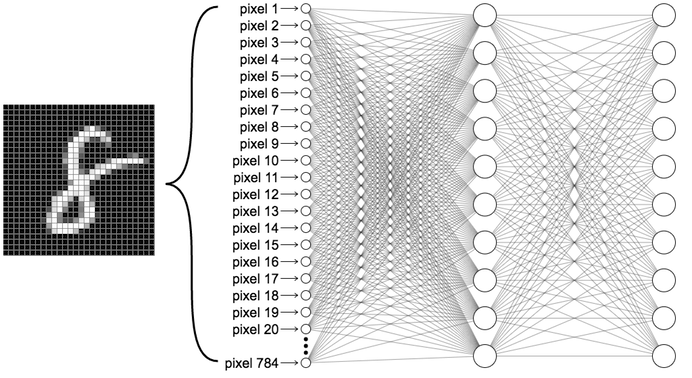

### Этапы построения модели:

* сначала растягиваем картинку в длинный вектор слоем `Flatten`
* потом идет полносвязный слой: нейроны в следующем слое зависят от всех переменных в предыдущем
* далее используем функцию активации `ReLU`
* потом идет следующий полносвязный слой, в котором $10$ выходов - по числу классов

**ReLU** - стандартный выбор для функции активации нейронов внутри нейросети. Несмотря на простоту функции, эксперименты показывают, что эта функция активации достаточна для эффективного обучения нейросетей.

**Softmax** - функция активации для выходного слоя нейронов в задачах классификации с числом классов $>2$. Она переводит выходные значения сети в вероятности принадлежности конкретного элемента выборки к одному из класов.

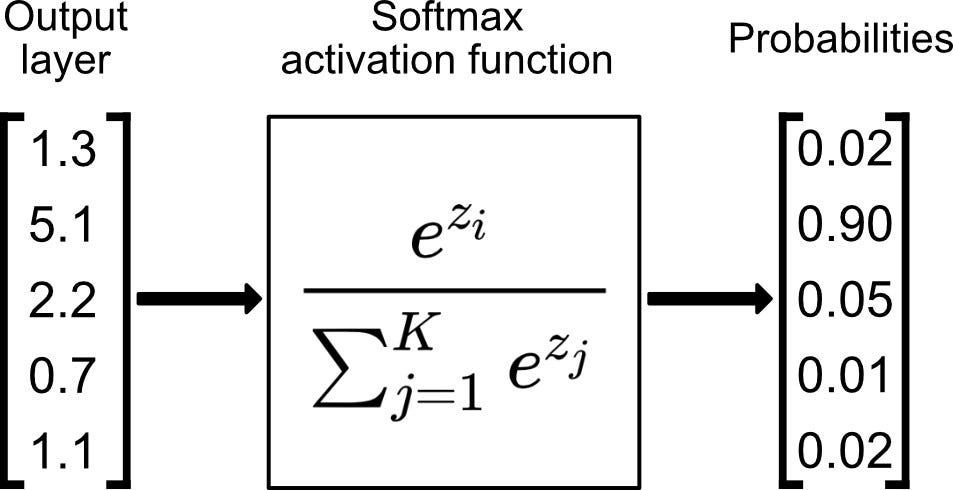

Модель в библиотеке PyTorch можно построить разными способами. Например, это можно сделать через через наследование классов. В нашем случае мы будем использовать контейнер `nn.Sequential`. В него поместим все слои и функции активации. Данные будут проходить через него постепенно, от слоя к слою.

In [51]:
# Определение модели
model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 512),
      nn.ReLU(),
      nn.Linear(512, 128),
      nn.ReLU(),
      nn.Linear(128, 10)
    )

In [98]:
# Эксперимент
model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28*28, 512), nn.ReLU(),
      nn.Linear(512, 256), nn.ReLU(),
      nn.Linear(256, 128), nn.ReLU(),
      nn.Linear(128, 64), nn.ReLU(),
      nn.Linear(64, 32), nn.ReLU(),
      nn.Linear(32, 16), nn.ReLU(),
      nn.Linear(16, 10)
    )

In [99]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=16, bias=True)
  (12): ReLU()
  (13): Linear(in_features=16, out_features=10, bias=True)
)

Модель в Pytorch  можно создать и по-другому, через класс. В `init` мы должны прописать все слои. В данном случае они сгруппированы в `nn.Sequential`, но их можно задать через различные переменные.

Метод `forward` принимает **x** - наши наблюдения. Их мы обрабатываем через слои и далее возвращаем предсказания.

In [53]:
class SimpleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 512), nn.ReLU(),
      nn.Linear(512, 128), nn.ReLU(),
      nn.Linear(128, 10)
    )

    # Слои можно задавать например так:
    # self.lin = nn.Linear(28*28, 128)

  def forward(self, x):
    y = self.model(x)
    return y

In [100]:
# Эксперимент
class SimpleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(28 * 28, 512), nn.ReLU(),
      nn.Linear(512, 256), nn.ReLU(),
      nn.Linear(256, 128), nn.ReLU(),
      nn.Linear(128, 64), nn.ReLU(),
      nn.Linear(64, 32), nn.ReLU(),
      nn.Linear(32, 16), nn.ReLU(),
      nn.Linear(16, 10)
    )

    # Слои можно задавать например так:
    # self.lin = nn.Linear(28*28, 128)

  def forward(self, x):
    y = self.model(x)
    return y

In [93]:
# Теперь модель нужно инициализировать
model = SimpleModel()

In [101]:
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=16, bias=True)
  (12): ReLU()
  (13): Linear(in_features=16, out_features=10, bias=True)
)

Вы можете заметить, что мы не использовали в нашей модели softmax. Связано это с тем, что функция потерь `CrossEntropyLoss` в библиотеке PyTorch уже включает рассчет вероятностей по классам, то есть softmax.

### Обучение нейросети

**Обучение** нейросети - изменение **весов** нейронов при помощи **backpropagation** (обратного распространения ошибки).

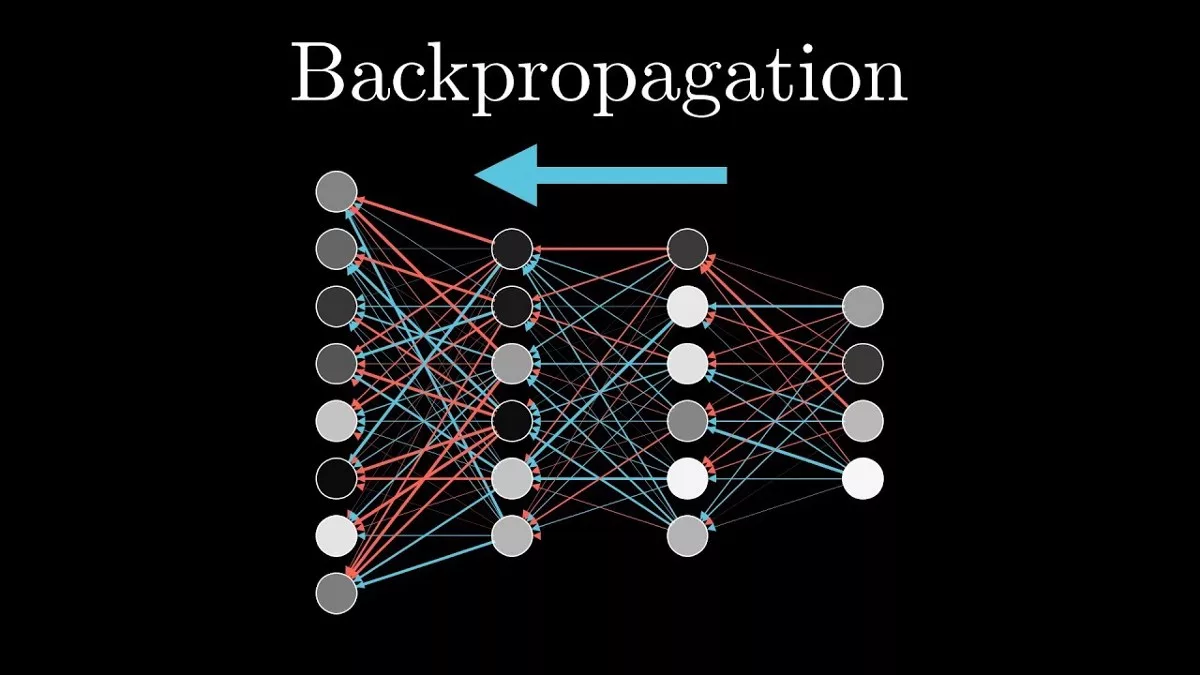

#### Алгоритм обучения

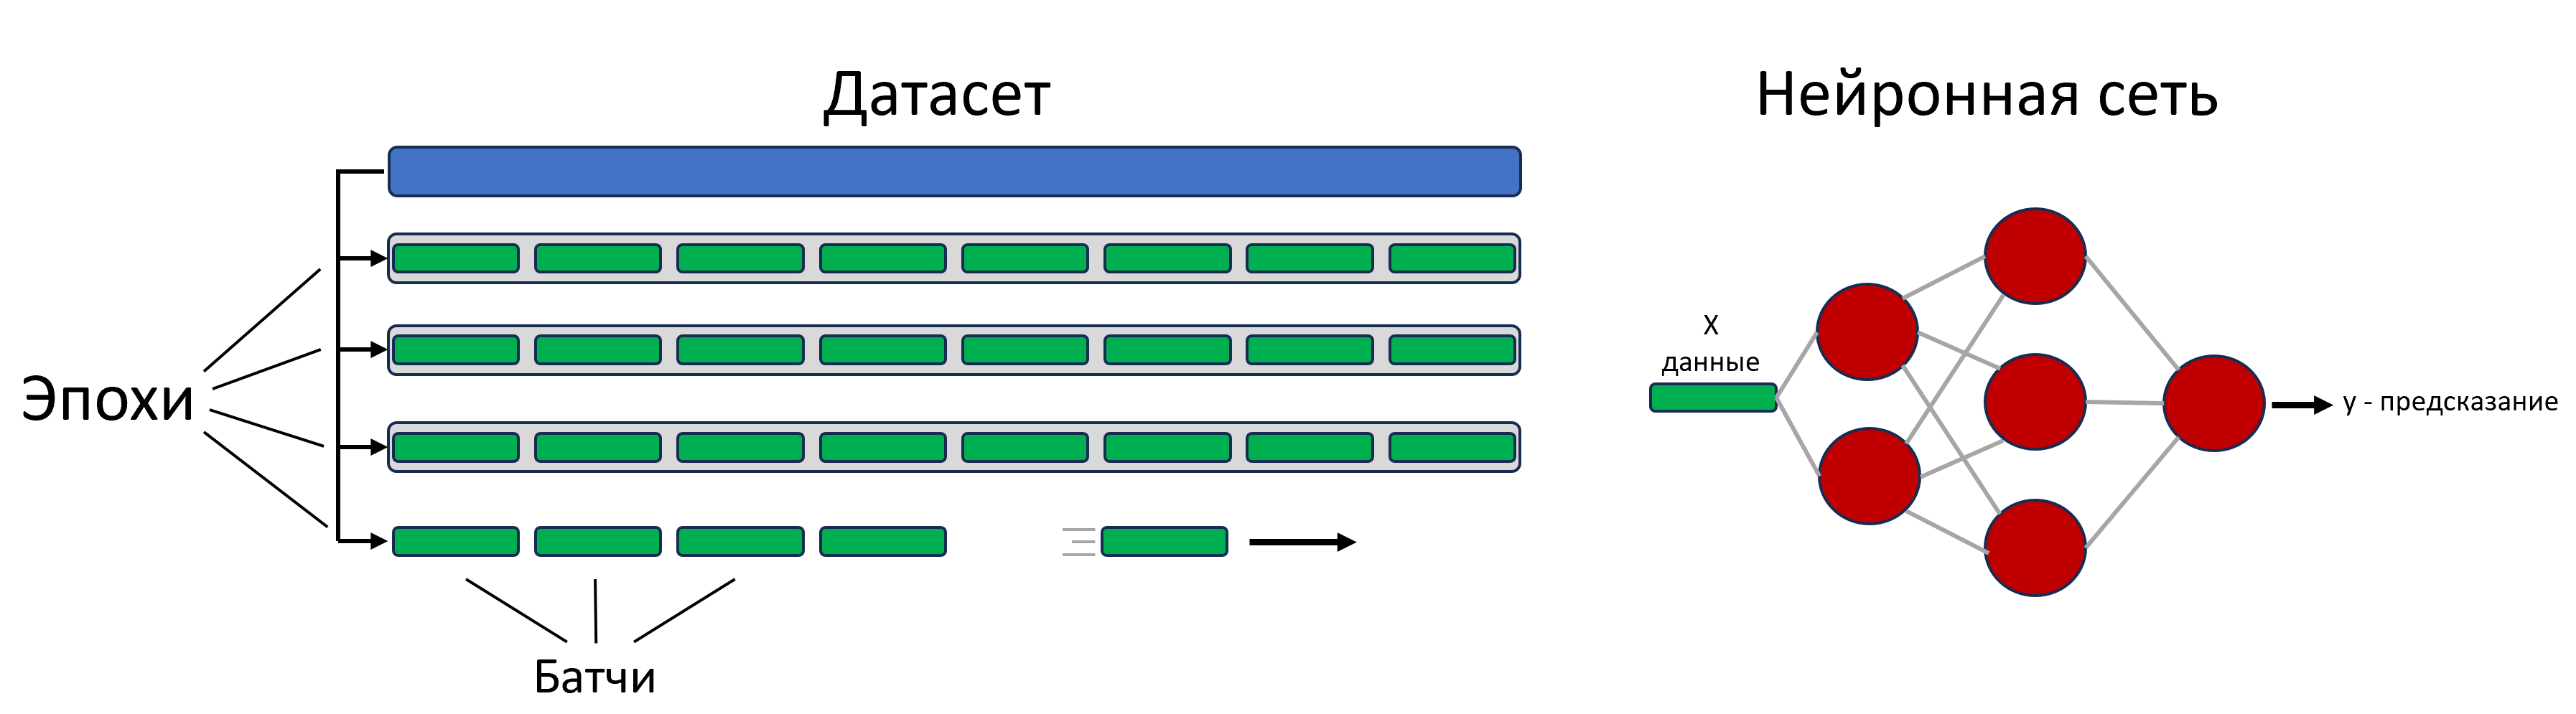

Подготовительный этап:

1. Разбить датасет на небольшие части (**батчи**), поскольку с точки зрения технических ограничений невозможно пропустить через нейросеть большой датасет целиком. Мы с вами это уже cделали.

2. Задать начальные значения весов нейросети (можно случайным образом, или конкретными распределениями, например, **Xavier**)

Обучение производится по **эпохам**. В каждую эпоху в нейросеть по батчам подается весь датасет, и пошагово обновляются веса модели.

##### Эпоха:

for Batch in Dataset
            
1.   Обнулить градиенты весов
2.   Посчитать значение функции потерь на батче
3.   Обратное распространение ошибки (посчитать градиенты для весов)
4.   Обновить веса

Обычно обучение повторяется много эпох, пока не будут достигнуты определенные условия (достигнуто пороговое значение, например, количество эпох или точность оптимизируемой метрики).

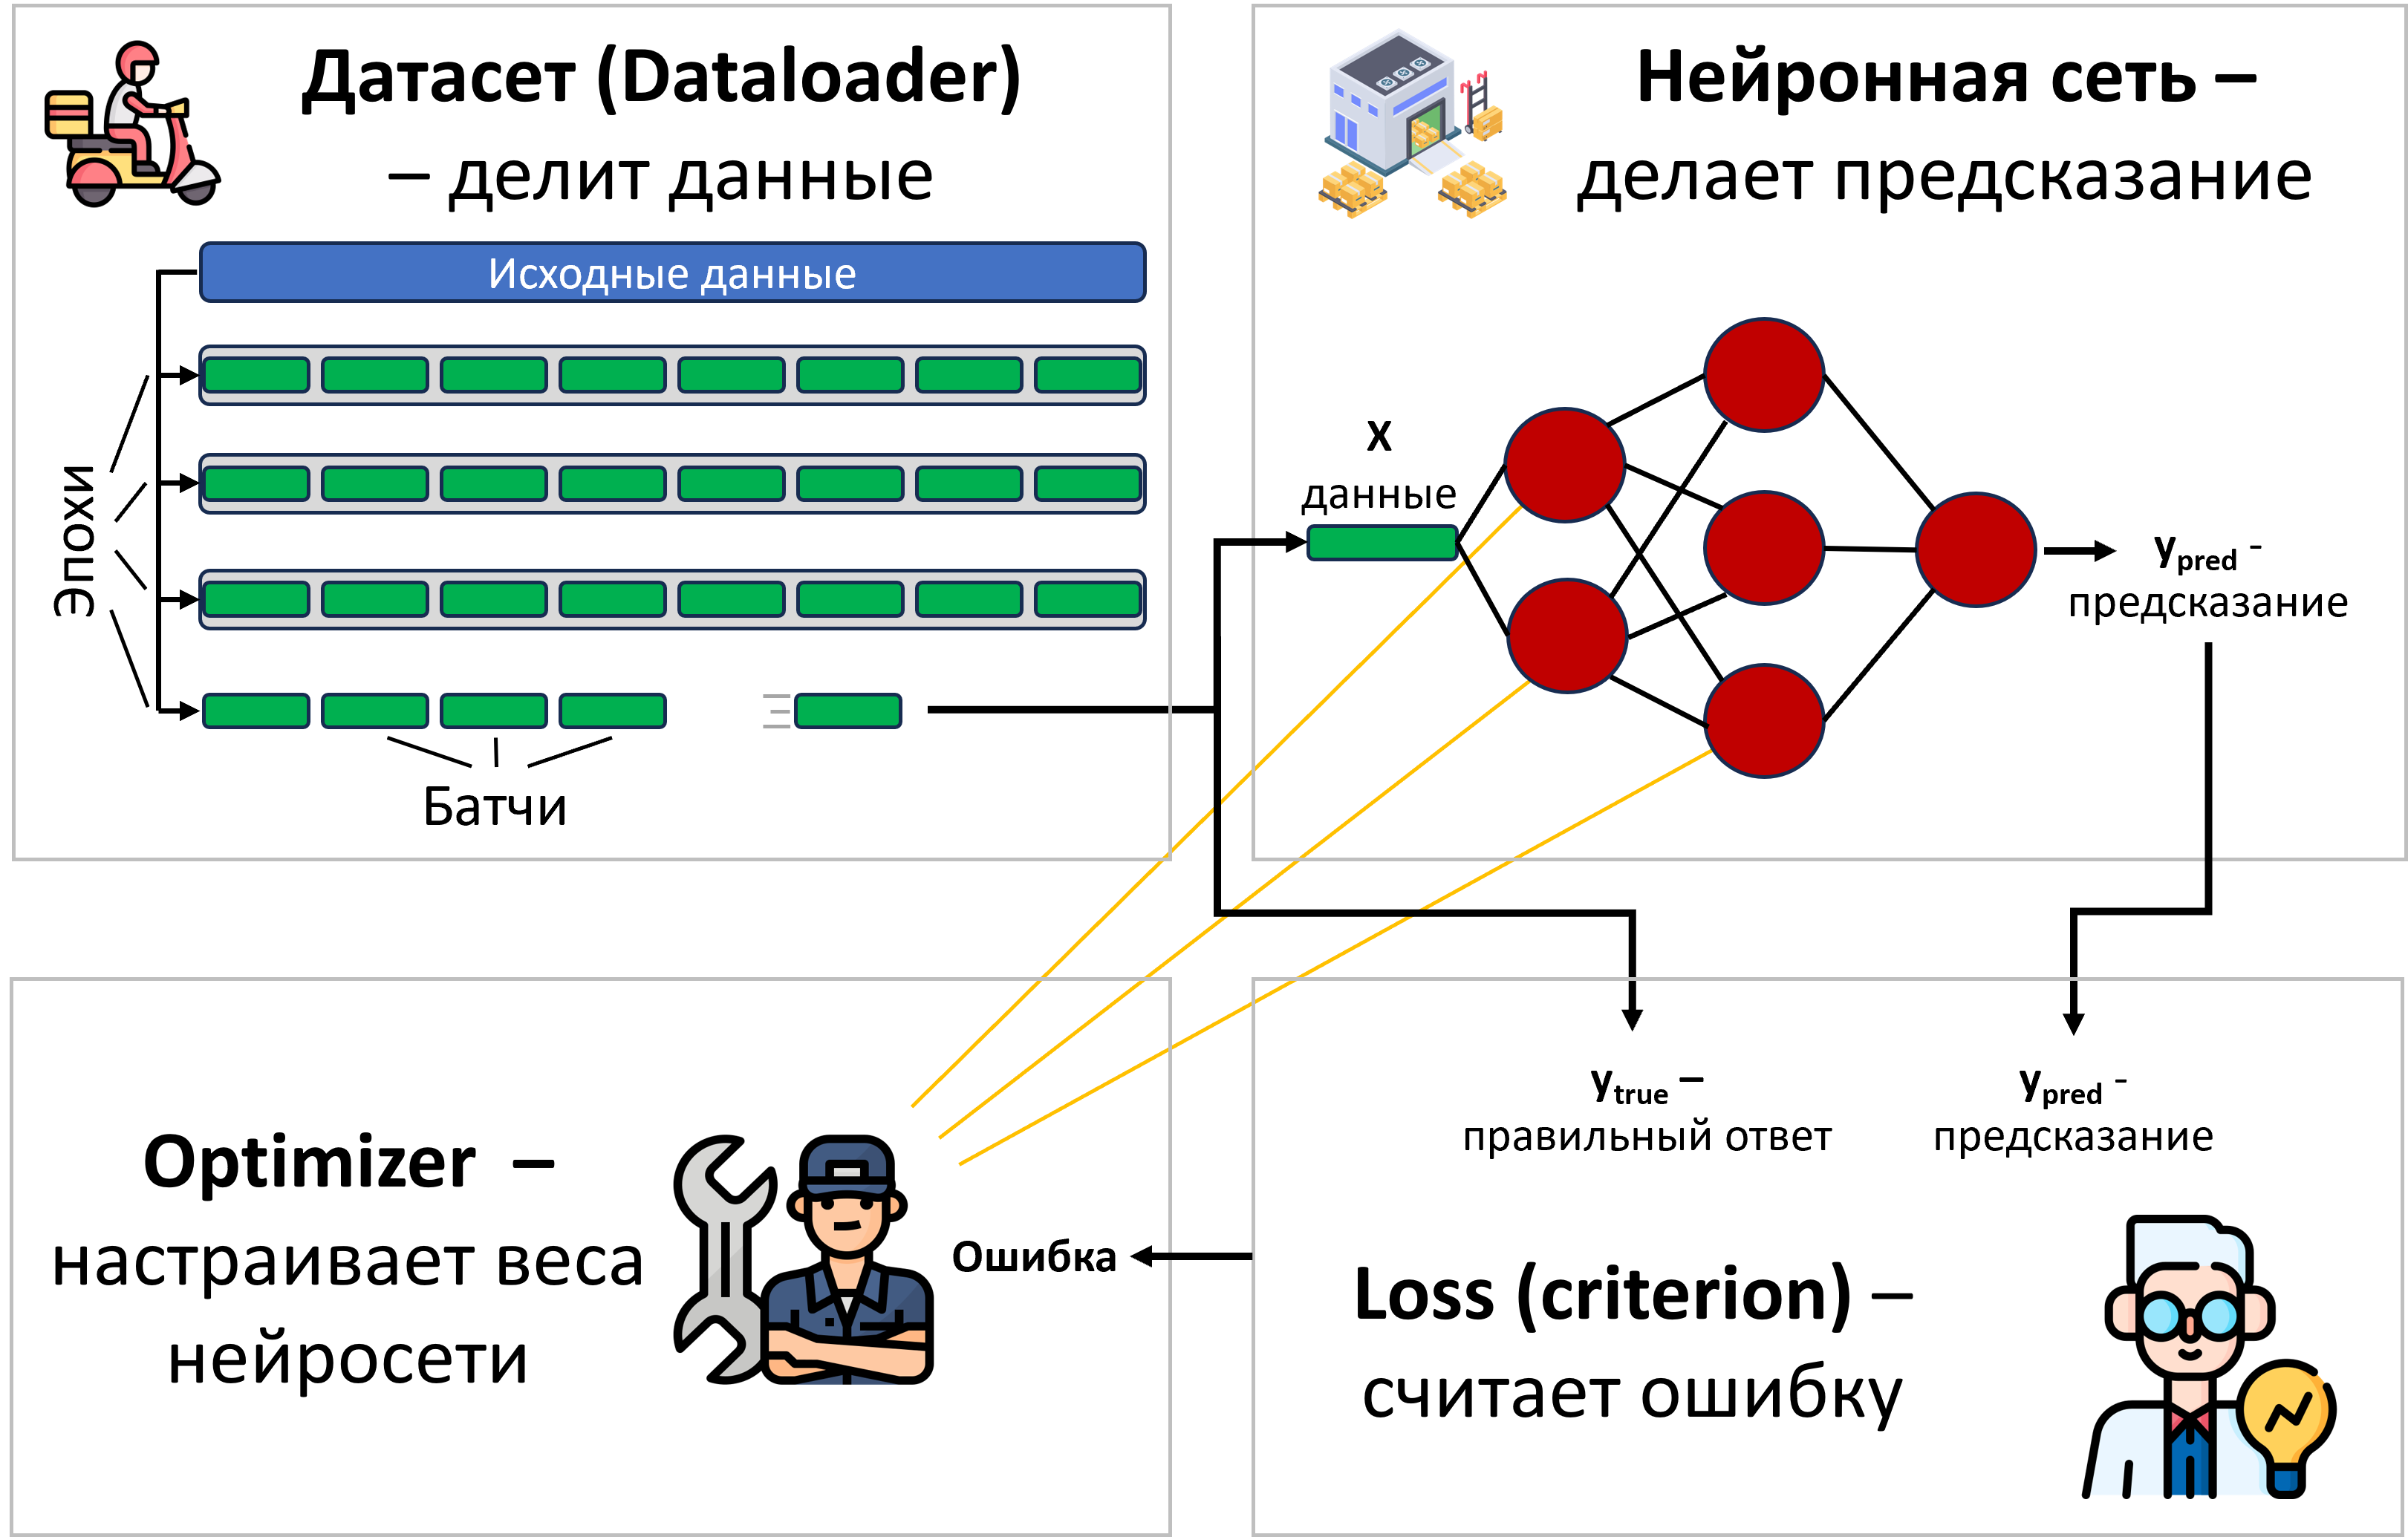

Всю работу по изменению весов и градиентов производит **оптимизатор**. Создадим его и функцию потерь. В оптимизатор мы должны передать все параметры нашей модели. Функцию потерь принято называть переменной `criterion`.

In [102]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

GPU позволяют обучать нейронные сети гораздо быстрее. Чтобы их использовать, нужно перенести все наши переменные на GPU. Для начала определим, есть ли он у вас:

In [103]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
device

'cuda'

Если ячейка выше вывела 'cpu', то вы не выбрали нужные настройки в Google Colab. Нужно поменять среду выпонения с CPU на T4. Если вы используете данный ноутбук локально, то, возможно, у вас нет видеокарты от NVIDIA или нужных драйверов cuda.

Переведем нашу модель на поддерживаемый девайс. Сами данные мы будем тоже переводить на его вычислительные мощности, но уже в самом цикле обучения.

In [104]:
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=128, bias=True)
  (6): ReLU()
  (7): Linear(in_features=128, out_features=64, bias=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): ReLU()
  (11): Linear(in_features=32, out_features=16, bias=True)
  (12): ReLU()
  (13): Linear(in_features=16, out_features=10, bias=True)
)

### Обучение модели
**Тренировка с указанием данных, числа эпох и размера подвыборки**

Теперь задана структура модели. Мы можем итерироваться по эпохам и батчам, и параметры будут оптимизироваться градиентным спуском.
При этом мы используем функцию потерь, которая подсчитана только по части полной выборки.

`num_epochs` - число эпох, сколько раз мы проходим полностью по всей выборке.

Количество эпох обычно выбирают так, чтобы метрика качества на валидационной выборке не начала ухудшаться (то есть не произошло переобучения).

В целом, подбор подобных гиперпараметров сети является отдельным классом задач, поскольку одна и та же архитектура нейросети может значительно улучшать/ухудшать результаты предсказаний в зависимости от выбранных значений.

In [105]:
# Функция обучения одной эпохи
def train_step(model, train_dataloader, optimizer):

    model.train() # Переводим модель в режим тренировки

    # Сохраняем различные статистики внутри эпохи
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Итерация по батчам в датасете
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        # Перемещение данных на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # Обнуление градиентов.
        # Без данной строчки, торч просто добавит их к предыдущим
        optimizer.zero_grad()

        # Прямой проход
        outputs = model(inputs) # Передаем изображения в модель
        loss = criterion(outputs, labels) # Считаем функцию потерь
        loss.backward() # Применяем обратное распространение ошибки
        optimizer.step() # Делаем шаг обучения

        # Статистика для вывода
        running_loss += loss.item()
        predicted = torch.argmax(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Вычисление среднего значения потерь и точности на эпохе
    train_accuracy = correct_predictions / total_samples
    average_loss = running_loss / len(train_dataloader)

    return average_loss, train_accuracy

def val_step(model, val_dataloader):
    # Режим для тестирования модели на val выборке
    model.eval()

    # Статистика для тестирования
    val_correct_predictions = 0
    val_total_samples = 0

    # Итерация по батчам в валидационном датасете
    with torch.no_grad():  # Не считаем градиенты, так как это тестирование
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Прямой проход
            outputs = model(inputs)

            # Статистика для вывода
            predicted = torch.argmax(outputs.data, 1)
            val_total_samples += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    # Вычисление точности на val выборке
    val_accuracy = val_correct_predictions / val_total_samples
    return val_accuracy


# общая функция для обучения
def train_model(model, train_dataloader, val_dataloader, optimizer, num_epochs=8):
    #Будем складывать accuracy на каждой эпохе
    train_accuracy_history = []
    val_accuracy_history = []

    for epoch in range(num_epochs): # Итерируемся по эпохам
        # шаг обучения
        average_loss, train_accuracy = train_step(model, train_dataloader, optimizer)
        train_accuracy_history.append(train_accuracy)

        #шаг тестирования
        val_accuracy = val_step(model, val_dataloader)
        val_accuracy_history.append(val_accuracy)

        # Вывод результатов
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Loss: {average_loss:.4f} | Train Accuracy: {train_accuracy:.4f} | Val Accuracy: {val_accuracy:.4f}')

    return train_accuracy_history, val_accuracy_history

In [106]:
%%time
#num_epochs = 13
num_epochs = 5
train_history, val_history = train_model(model, train_loader, val_loader, optimizer, num_epochs)

Epoch 1/5
Loss: 2.3116 | Train Accuracy: 0.0992 | Val Accuracy: 0.1000
Epoch 2/5
Loss: 2.3115 | Train Accuracy: 0.0992 | Val Accuracy: 0.1000
Epoch 3/5
Loss: 2.3115 | Train Accuracy: 0.0992 | Val Accuracy: 0.1000
Epoch 4/5
Loss: 2.3113 | Train Accuracy: 0.0992 | Val Accuracy: 0.1000
Epoch 5/5
Loss: 2.3115 | Train Accuracy: 0.0992 | Val Accuracy: 0.1000
CPU times: user 55.2 s, sys: 103 ms, total: 55.3 s
Wall time: 55.5 s


### 5. Валидация качества модели на тестовых данных.
Протестируем модель на тестовой выборке, использую функцию `val_step`.

In [61]:
val_step(model, test_loader) # Результат 0.8894

0.134

## Выводы





Что мы разобрали в этом семинаре?

1. Вспомнили, как работать с **базовыми подходами** для задачи классификации и запустили их на датасете MNIST.  

2. Познакомились с **нейросетями** и основными терминами: **нейрон**, **слои**, **функция активации**, **функция ошибки (loss)**, **обучение/тренировка**, **батч**, **эпоха**...

3. Познакомились с библиотекой для обучения нейронных сетей **PyTorch**.

4. На примере MNIST - одного из самых популярных датасетов, содержащих черно-белые картинки, посмотрели, как строить нейросети для решения задачи **классификации**.